In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score,roc_curve
from lightgbm import LGBMClassifier,plot_importance
from sklearn.preprocessing import StandardScaler
from yellowbrick.classifier import roc_auc
from sklearn.metrics import roc_auc_score, roc_curve
import plotly.graph_objects as go
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import KFold

/Users/veraburdi/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def plot_roc(proba, y_true):
    fpr, tpr, th = roc_curve(y_true, proba)
    auc = round(roc_auc_score(y_true, proba), 5)
    
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, linestyle='-', c='r', label=f'AUC: {auc}')
    
    plt.xlabel('False Positive Rate', fontsize = 20)
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.legend(fontsize = 20)
    plt.show()


In [3]:
def cross_val_eval(model, df):
    kf5 = KFold(n_splits=5, shuffle=True)
    i = 0
    for train_index, test_index in kf5.split(df):
        X_train = df.iloc[train_index]
        X_test = df.iloc[test_index]
        y_train = df.iloc[train_index, "CHURN"].loc[:, "CHURN"]
        y_test = df.iloc[test_index].loc[:, "CHURN"]
        model.fit(X_train, y_train)
        print(f"Accuracy for the fold number {i} on the test set:{round(roc_auc_score(y_test, model.predict(X_test)), 5)}")
        i += 1

In [4]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
train.shape,test.shape

((2154048, 18), (380127, 17))

In [5]:
train.head(3)

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
user_id,,,,,,,,,,,,,,,,,,
00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0


In [6]:
# unbalanced classes
np.sum(train.CHURN) / train.shape[0]

0.1875473527052322

In [7]:
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_df = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})
missing_value_df.loc[missing_value_df.percent_missing != 0]

,column_name,percent_missing
REGION,REGION,39.428044
MONTANT,MONTANT,35.131018
FREQUENCE_RECH,FREQUENCE_RECH,35.131018
REVENUE,REVENUE,33.706213
ARPU_SEGMENT,ARPU_SEGMENT,33.706213
FREQUENCE,FREQUENCE,33.706213
DATA_VOLUME,DATA_VOLUME,49.229776
ON_NET,ON_NET,36.520774
ORANGE,ORANGE,41.561191
TIGO,TIGO,59.887988


In [8]:
#add Nan feature
train['sum_nan'] = np.sum(train.isna(), axis = 1)
test['sum_nan'] = np.sum(test.isna(), axis = 1)

In [9]:
X = train.drop('CHURN',axis=1)
y  = train.CHURN.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, 
                                                    shuffle = True, stratify = y)

# NaN Processing

In [10]:
def process_nan(df, train):
    for col in list(df.columns):
        if col in list(df._get_numeric_data().columns):
            df[col] = df[col].replace(np.NaN, train[col].mean())
        else:
            df[col] = df[col].replace(np.NaN, 'Unknown')

In [7]:
# if there is no information on such calls is more likeky that there were no calls to these operators

X_train['ZONE1'] = X_train['ZONE1'].replace(np.NaN, 0)
X_val['ZONE1'] = X_val['ZONE1'].replace(np.NaN, 0)
test['ZONE1'] = test['ZONE1'].replace(np.NaN, 0)

X_train['ZONE2'] = X_train['ZONE2'].replace(np.NaN, 0)
X_val['ZONE2'] = X_val['ZONE2'].replace(np.NaN, 0)
test['ZONE2'] = test['ZONE2'].replace(np.NaN, 0)

X_train['ORANGE'] = X_train['ORANGE'].replace(np.NaN, 0)
X_val['ORANGE'] = X_val['ORANGE'].replace(np.NaN, 0)
test['ORANGE'] = test['ORANGE'].replace(np.NaN, 0)

X_train['TIGO'] = X_train['TIGO'].replace(np.NaN, 0)
X_val['TIGO'] = X_val['TIGO'].replace(np.NaN, 0)
test['TIGO'] = test['TIGO'].replace(np.NaN, 0)

X_train['ON_NET'] = X_train['ON_NET'].replace(np.NaN, 0)
X_val['ON_NET'] = X_val['ON_NET'].replace(np.NaN, 0)
test['ON_NET'] = test['ON_NET'].replace(np.NaN, 0)

In [11]:
process_nan(X_train, X_train)
process_nan(X_val, X_train)
process_nan(test, X_train)

/Users/veraburdi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/veraburdi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# Add and delete some features

In [12]:
print(train.MRG.unique())
print(test.MRG.unique())

['NO']
['NO']


In [13]:
del X_train['MRG']
del X_val['MRG']
del test['MRG']

In [14]:
d = {'K > 24 month' : 25.5, 'I 18-21 month' : 19.5, 'H 15-18 month' : 16.5, 'G 12-15 month' : 13.5, 
    'J 21-24 month' : 22.5, 'F 9-12 month' : 10.5, 'E 6-9 month' : 7.5, 'D 3-6 month' : 4.5}
X_train['TENURE'] = X_train['TENURE'].map(d)
X_val['TENURE'] = X_val['TENURE'].map(d)
test['TENURE'] = test['TENURE'].map(d)

/Users/veraburdi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/veraburdi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [15]:
for c in X_train.columns:
    col_type = X_train[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_train[c] = X_train[c].astype('category')
        
for c in X_val.columns:
    col_type = X_val[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_val[c] = X_val[c].astype('category')
        
for c in test.columns:
    col_type = test[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        test[c] = test[c].astype('category')

/Users/veraburdi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/veraburdi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [16]:
X_train['total_calls'] = X_train['ON_NET'] + X_train['ORANGE'] +\
    X_train['TIGO'] + X_train['ZONE1'] + X_train['ZONE2']

test['total_calls'] = test['ON_NET'] + test['ORANGE'] +\
    test['TIGO'] + test['ZONE1'] + test['ZONE2']

X_val['total_calls'] = X_val['ON_NET'] + X_val['ORANGE'] +\
    X_val['TIGO'] + X_val['ZONE1'] + X_val['ZONE2']


# 2. MONTANT / FREQUENCE_RECH (средняя сумма пополнения)
X_train['MONTANT/FREQUENCE_RECH']  = X_train['MONTANT'] / (X_train['FREQUENCE_RECH'] + 0.0001)
test['MONTANT/FREQUENCE_RECH']  = test['MONTANT'] / (test['FREQUENCE_RECH'] + 0.0001)
X_val['MONTANT/FREQUENCE_RECH']  = X_val['MONTANT'] / (X_val['FREQUENCE_RECH'] + 0.0001)


# 3. ARPU_SEGMENT * 3 - MONTANT (сколько оставалось после пополнений)
X_train['remains'] = X_train['ARPU_SEGMENT'] * 3 - X_train['MONTANT']
test['remains'] = test['ARPU_SEGMENT'] * 3 - test['MONTANT']
X_val['remains'] = X_val['ARPU_SEGMENT'] * 3 - X_val['MONTANT']


# 4. DATA_VOLUME / REGULARITY (плотность активности, т.е. число подкючений на число входов в сеть)
X_train['activ_density'] = X_train['DATA_VOLUME'] / (X_train['REGULARITY'] + 0.0001)
test['activ_density'] = test['DATA_VOLUME'] / (test['REGULARITY'] + 0.0001)
X_val['activ_density'] = X_val['DATA_VOLUME'] / (X_val['REGULARITY'] + 0.0001)


# 5. общее число звонков / REGULARITY
X_train['calls_density'] = X_train['total_calls'] / (X_train['REGULARITY'] + 0.0001)
test['calls_density'] = test['total_calls'] / (test['REGULARITY'] + 0.0001)
X_val['calls_density'] = X_val['total_calls'] / (X_val['REGULARITY'] + 0.0001)

# 6.
X_train['arpu_last_to_average'] = X_train['ARPU_SEGMENT'] / (X_train['REVENUE'] + 0.0001)
test['arpu_last_to_average'] = test['ARPU_SEGMENT'] / (test['REVENUE'] + 0.0001)
X_val['arpu_last_to_average'] = X_val['ARPU_SEGMENT'] / (X_val['REVENUE'] + 0.0001)

/Users/veraburdi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/veraburdi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/veraburdi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

# Encode categorical features

In [17]:
from category_encoders import TargetEncoder

In [18]:
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()
test_enc = test.copy()

encoder = TargetEncoder()
X_train_enc['TOP_PACK_ENC'] = encoder.fit_transform(X_train_enc['TOP_PACK'], y_train)
X_val_enc['TOP_PACK_ENC'] = encoder.transform(X_val_enc['TOP_PACK'])
test_enc['TOP_PACK_ENC'] = encoder.transform(test['TOP_PACK'])

encoder = TargetEncoder()
X_train_enc['REGION_ENC'] = encoder.fit_transform(X_train_enc['REGION'], y_train)
X_val_enc['REGION_ENC'] = encoder.transform(X_val_enc['REGION'])
test_enc['REGION_ENC'] = encoder.transform(test['REGION'])

del X_train_enc['TOP_PACK']
del X_val_enc['TOP_PACK']
del test_enc['TOP_PACK']

del X_train_enc['REGION']
del X_val_enc['REGION']
del test_enc['REGION']

In [23]:
X_val_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 646215 entries, 96692123fab7d3114cb5524b3858bdf7751383a5 to e8fb464fedb2d7577146e0c53fd0a9e3439c38aa
Data columns (total 24 columns):
TENURE                    646215 non-null float64
MONTANT                   646215 non-null float64
FREQUENCE_RECH            646215 non-null float64
REVENUE                   646215 non-null float64
ARPU_SEGMENT              646215 non-null float64
FREQUENCE                 646215 non-null float64
DATA_VOLUME               646215 non-null float64
ON_NET                    646215 non-null float64
ORANGE                    646215 non-null float64
TIGO                      646215 non-null float64
ZONE1                     646215 non-null float64
ZONE2                     646215 non-null float64
REGULARITY                646215 non-null int64
FREQ_TOP_PACK             646215 non-null float64
sum_nan                   646215 non-null int64
total_calls               646215 non-null float64
MONTANT/FREQUENCE_RECH   

# Clustering

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import DBSCAN

In [20]:
scaler = StandardScaler()
scaler.fit(X_train_enc)
X_train_enc_sc = scaler.transform(X_train_enc)
X_val_enc_sc = scaler.transform(X_val_enc)
test_enc_sc = scaler.transform(test_enc)

In [24]:
clustering = KMeans(n_clusters=3, random_state=42).fit(X_train_enc_sc)
X_train_enc['cluster'] = clustering.predict(X_train_enc_sc)
X_val_enc['cluster'] = clustering.predict(X_val_enc_sc)
test_enc['cluster'] = clustering.predict(test_enc_sc)

In [26]:
random_indices = np.random.choice(X_train_enc_sc.shape[0], size=10000, replace=False)

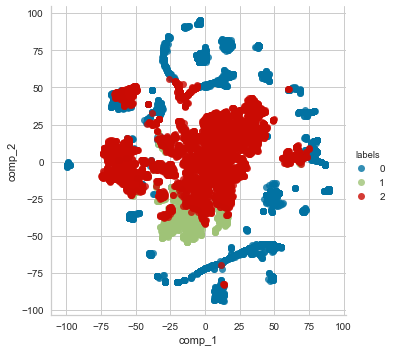

In [37]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE()
X_tsne = tsne.fit_transform(X_train_enc_sc[random_indices, :])  

# matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
proj = pd.DataFrame(X_tsne)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = X_train['cluster'].values[random_indices]
sns.lmplot("comp_1", "comp_2", hue = "labels", data = proj, fit_reg=False)

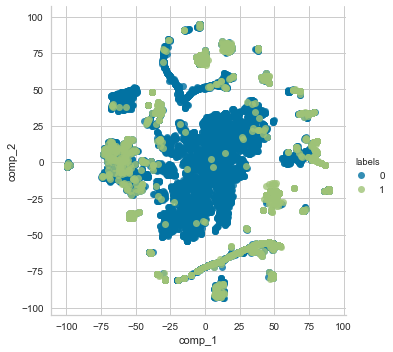

In [38]:
proj = pd.DataFrame(X_tsne)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = X_train['CHURN'].values[random_indices]
sns.lmplot("comp_1", "comp_2", hue = "labels", data = proj, fit_reg=False)

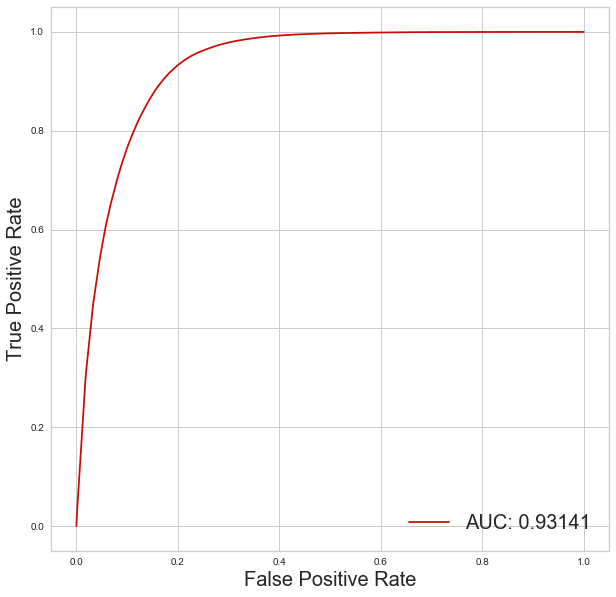

In [34]:
light = LGBMClassifier(n_estimators=200, learning_rate=0.05,
                      min_child_samples=30, num_leaves=127, is_unbalance=True)
light.fit(X_train_enc, y_train)

proba = light.predict_proba(X_val_enc)
plot_roc(proba[:, 1], y_val)

In [35]:
prediction = light.predict_proba(test_enc)
final = pd.DataFrame()
final['user_id'] = test_enc.index
final['CHURN'] = prediction[:, 1]
final.to_csv("submission.csv", index = False)

In [38]:
train1 = X_train_enc[X_train_enc['cluster'] == 0]
X1 = train1
y1  = y_train[X_train_enc['cluster'] == 0]

train2 = X_train_enc[X_train_enc['cluster'] == 1]
X2 = train2
y2  = y_train[X_train_enc['cluster'] == 1]

train3 = X_train_enc[X_train_enc['cluster'] == 2]
X3 = train3
y3  = y_train[X_train_enc['cluster'] == 2]

light1 = LGBMClassifier(n_estimators=200, learning_rate=0.05,
                      min_child_samples=30, num_leaves=127, is_unbalance=True)
light1.fit(X1, y1)

light2 = LGBMClassifier(n_estimators=200, learning_rate=0.05,
                      min_child_samples=30, num_leaves=127, is_unbalance=True)
light2.fit(X2, y2)

light3 = LGBMClassifier(n_estimators=200, learning_rate=0.05,
                      min_child_samples=30, num_leaves=127, is_unbalance=True)
light3.fit(X3, y3)

LGBMClassifier(is_unbalance=True, learning_rate=0.05, min_child_samples=30,
               n_estimators=200, num_leaves=127)

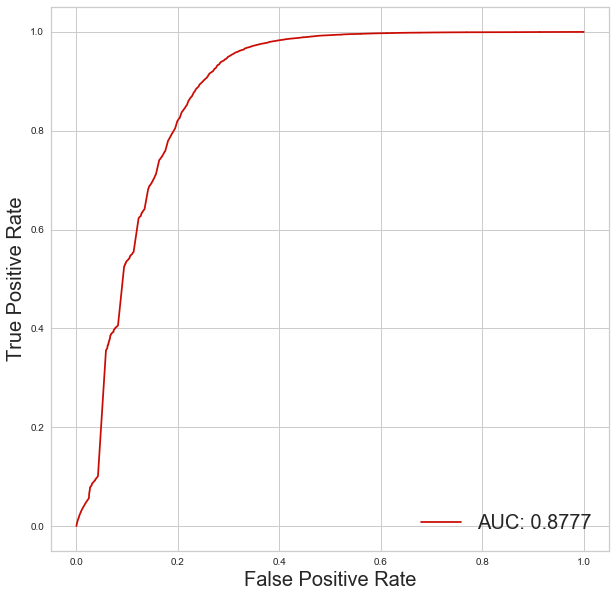

In [39]:
result = X_val_enc.copy()
result['prediction'] = 0.0

result.loc[X_val_enc['cluster'] == 0, 'prediction'] = light1.predict_proba(X_val_enc[X_val_enc['cluster'] == 0])[:, 1]
result.loc[X_val_enc['cluster'] == 1, 'prediction'] = light2.predict_proba(X_val_enc[X_val_enc['cluster'] == 1])[:, 1]
result.loc[X_val_enc['cluster'] == 2, 'prediction'] = light3.predict_proba(X_val_enc[X_val_enc['cluster'] == 2])[:, 1]

plot_roc(result['prediction'], y_val)

In [40]:
result = test_enc.copy()
result['prediction'] = 0.0

result.loc[test_enc['cluster'] == 0, 'prediction'] = light1.predict_proba(test_enc[test_enc['cluster'] == 0])[:, 1]
result.loc[test_enc['cluster'] == 1, 'prediction'] = light2.predict_proba(test_enc[test_enc['cluster'] == 1])[:, 1]
result.loc[test_enc['cluster'] == 2, 'prediction'] = light3.predict_proba(test_enc[test_enc['cluster'] == 2])[:, 1]

final = pd.DataFrame()
final['user_id'] = test_enc.index
final['CHURN'] = result['prediction'].values
final.to_csv("submission.csv", index = False)

# LightGBM

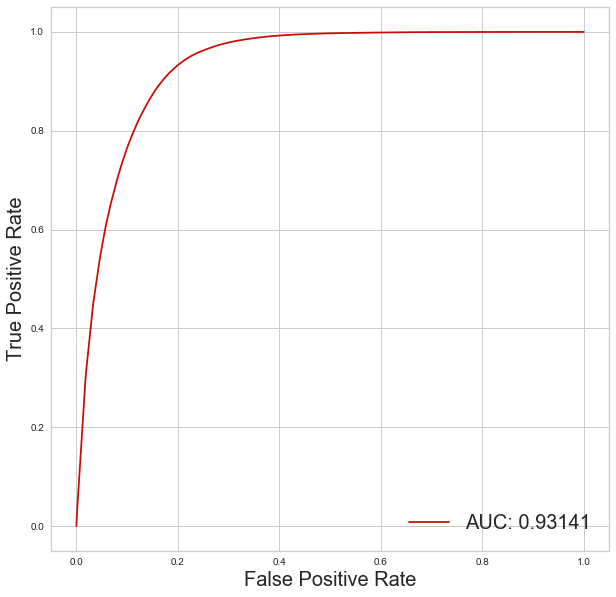

In [44]:
X_train = X_train_enc.copy()
X_val = X_val_enc.copy()
test = test_enc.copy()

light = LGBMClassifier(n_estimators=200, learning_rate=0.05,
                      min_child_samples=30, num_leaves=127, is_unbalance=True)
light.fit(X_train, y_train)

proba = light.predict_proba(X_val)
plot_roc(proba[:, 1], y_val)

In [45]:
prediction = light.predict_proba(test)
final = pd.DataFrame()
final['user_id'] = test.index
final['CHURN'] = prediction[:, 1]
final.to_csv("submission.csv", index = False)

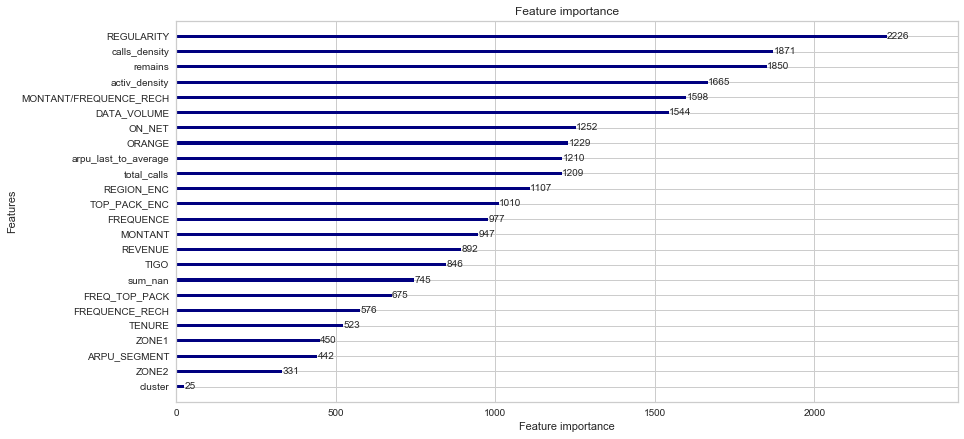

In [46]:
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(light,color='navy',)

# Parameters tuning

In [48]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_val, y_val)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [49]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [50]:
n_HP_points_to_test = 100
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = LGBMClassifier(max_depth=-1, random_state=42, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [51]:
# gs.fit(X_train, y_train, **fit_params)
# print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [52]:
for n_estimators in [100, 200, 300]:
    light = LGBMClassifier(n_estimators=n_estimators, learning_rate=0.05,
                      min_child_samples=30, num_leaves=60, is_unbalance=True)
    light.fit(X_train, y_train)
    proba = light.predict_proba(X_val)
    print(n_estimators, roc_auc_score(y_val, proba[:, 1]))

100 0.9312950355515514
200 0.9313946530638119
300 0.9314128628439227


In [53]:
for num_leaves in [15, 31, 63, 127, 255]:
    light = LGBMClassifier(n_estimators=300, learning_rate=0.05,
                      min_child_samples=30, num_leaves=num_leaves, is_unbalance=True)
    light.fit(X_train, y_train)
    proba = light.predict_proba(X_val)
    print(num_leaves, roc_auc_score(y_val, proba[:, 1]))

15 0.9312432561785657
31 0.9313440819220861
63 0.9313944556496995
127 0.9313966171153888
255 0.931323573147257


In [54]:
for learning_rate in [0.03, 0.05, 0.07]:
    light = LGBMClassifier(n_estimators=200, learning_rate=learning_rate,
                      min_child_samples=30, num_leaves=127, is_unbalance=True)
    light.fit(X_train, y_train)
    proba = light.predict_proba(X_val)
    print(learning_rate, roc_auc_score(y_val, proba[:, 1]))

0.03 0.9314176809568134
0.05 0.9314134243068517
0.07 0.9313506706171091


In [55]:
for min_child_samples in [10, 20, 30, 40, 50]:
    light = LGBMClassifier(n_estimators=200, learning_rate=0.05,
                      min_child_samples=min_child_samples, num_leaves=127, is_unbalance=True)
    light.fit(X_train, y_train)
    proba = light.predict_proba(X_val)
    print(min_child_samples, roc_auc_score(y_val, proba[:, 1]))

10 0.9313241384369852
20 0.9314004199399852
30 0.9314134243068517
40 0.9314308844115259
50 0.9314350739549908


# CatBoost

In [56]:
import catboost
from catboost import CatBoostClassifier

In [60]:
clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    loss_function='CrossEntropy'
)


clf.fit(X_train, y_train, 
        eval_set=(X_val, y_val), 
        verbose=False
)

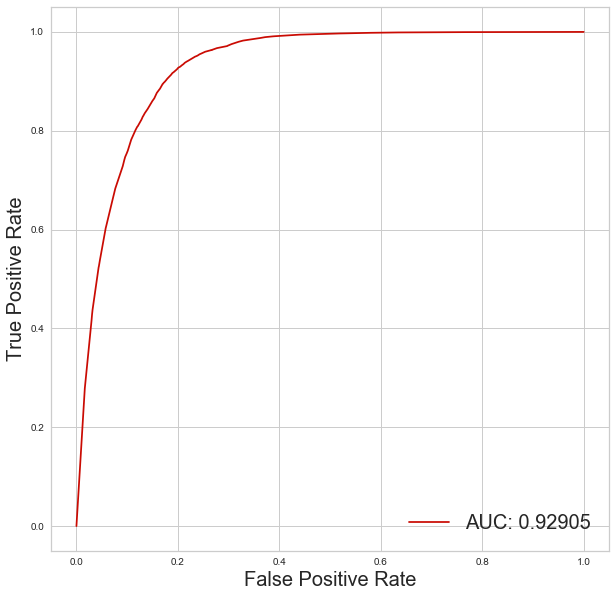

In [61]:
plot_roc(clf.predict_proba(X_val)[:, 1], y_val)

In [62]:
clf.feature_importances_

array([ 0.        ,  0.        ,  0.13485708,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 25.85651107,  0.        ,  0.987453  ,
        0.        ,  0.65670806,  0.        ,  0.8320352 ,  0.82843517,
        0.        ,  1.38466308, 69.31933733,  0.        ])

# XGBoost

In [63]:
import xgboost

In [64]:
xgb = xgboost.XGBClassifier(learning_rate = 0.1, alpha = 1, n_estimators = 400, scale_pos_weight=10)
xgb.fit(X_train_enc, y_train)

/Users/veraburdi/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[23:34:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=10, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

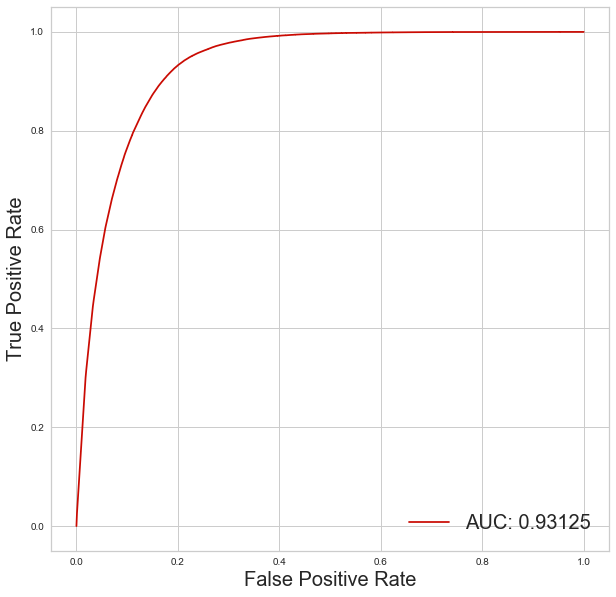

In [65]:
plot_roc(xgb.predict_proba(X_val_enc)[:, 1], y_val)